In [1]:
%matplotlib inline
import pandas as pd
import tensorflow as tf
import numpy as np
from preprocessing import *
from model import *
import math
import matplotlib.pyplot as plt
seed = 42

# to autoreload modules on code change
%load_ext autoreload
%autoreload 2

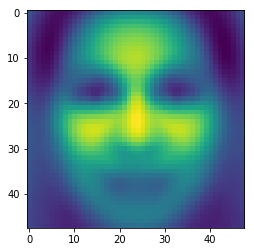

In [2]:
X_train, y_train, X_val, y_val, X_test, y_test = get_emotion_data()
# Displays average image

In [3]:
y_train = y_train.reshape(-1)
y_val = y_val.reshape(-1)
y_test = y_test.reshape(-1)

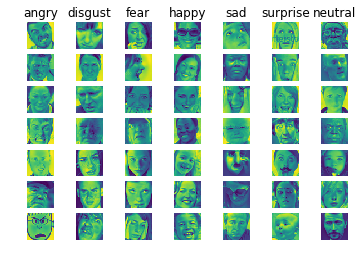

In [4]:
classes = ['angry','disgust','fear','happy','sad','surprise','neutral']
num_classes = len(classes)
samples_per_class = 7
for y,cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].reshape(48,48)) #pixel height and width
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [57]:
def run_model(session, predict, loss_val, Xd, yd,
              epochs=1, batch_size=64, print_every=100,
              training=None, plot_losses=False, global_step_incrementer = None,lrr=None):
    # have tensorflow compute accuracy
    correct_prediction = tf.equal(tf.argmax(predict,1), y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # shuffle indicies
#     tf.set_random_seed(seed)
    np.random.seed(seed)
    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)

    training_now = training is not None
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [lrr,mean_loss,correct_prediction,accuracy]
    if training_now:
        variables[-1] = training
        if global_step_incrementer is not None:
            variables += [global_step_incrementer]
    
    # counter 
    iter_cnt = 0
    for e in range(epochs):
        # keep track of losses and accuracy
        correct = 0
        losses = []
        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
            # generate indicies for the batch
            start_idx = (i*batch_size)%Xd.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            feed_dict = {X: Xd[idx,:],
                         y: yd[idx],
                         is_training: training_now }
            # get batch size
            actual_batch_size = yd[idx].shape[0]
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            if global_step_incrementer is None:
                if training_now:
                    lrate,loss, corr, _ = session.run(variables,feed_dict=feed_dict)
                else:
                    loss, corr, _ = session.run(variables[1:],feed_dict=feed_dict)
            else:
                lrate,loss, corr, _, _ = session.run(variables,feed_dict=feed_dict)
                
            # aggregate performance stats
            losses.append(loss * actual_batch_size)
            correct += np.sum(corr)
            
            # print every now and then
#             print(accuracy.eval())
            if training_now and (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.2g}"\
                      .format(iter_cnt,loss,np.sum(corr)/actual_batch_size))
                print("lrate = " + str(lrate))
            iter_cnt += 1
        total_correct = correct/Xd.shape[0]
        total_loss = np.sum(losses)/Xd.shape[0]
        print("Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.3g}"\
              .format(total_loss,total_correct,e+1))
#         if not training_now:
#             print()
#             break
#         print('\nValidation')
#         run_model(session,y_out,mean_loss,X_val,y_val,1,64)
        if plot_losses:
#             print(losses[-1],losses[-2])
            plt.plot(losses)
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
    return total_loss,total_correct

# model1
A simple 3 layered feed forward neural net with 100 units in each hidden layer with xaviers initialisation

Training
Iteration 0: with minibatch training loss = 49.7 and accuracy of 0.25
lrate = 0.00499974
Iteration 100: with minibatch training loss = 7.01 and accuracy of 0.094
lrate = 0.00494871
Iteration 200: with minibatch training loss = 1.85 and accuracy of 0.31
lrate = 0.00489821
Iteration 300: with minibatch training loss = 1.84 and accuracy of 0.2
lrate = 0.00484822
Iteration 400: with minibatch training loss = 1.8 and accuracy of 0.3
lrate = 0.00479873
Epoch 1, Overall loss = 19.3 and accuracy of 0.231


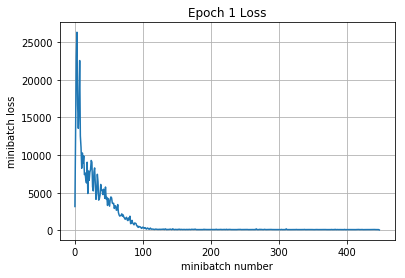

Iteration 500: with minibatch training loss = 1.76 and accuracy of 0.3
lrate = 0.00474976
Iteration 600: with minibatch training loss = 1.9 and accuracy of 0.19
lrate = 0.00470128
Iteration 700: with minibatch training loss = 1.76 and accuracy of 0.28
lrate = 0.0046533
Iteration 800: with minibatch training loss = 1.84 and accuracy of 0.34
lrate = 0.0046058
Epoch 2, Overall loss = 1.82 and accuracy of 0.253


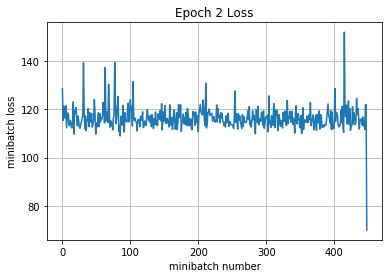

Iteration 900: with minibatch training loss = 1.9 and accuracy of 0.19
lrate = 0.0045588
Iteration 1000: with minibatch training loss = 1.9 and accuracy of 0.27
lrate = 0.00451227
Iteration 1100: with minibatch training loss = 1.79 and accuracy of 0.22
lrate = 0.00446622
Iteration 1200: with minibatch training loss = 1.84 and accuracy of 0.23
lrate = 0.00442063
Iteration 1300: with minibatch training loss = 1.79 and accuracy of 0.22
lrate = 0.00437574
Epoch 3, Overall loss = 1.81 and accuracy of 0.253


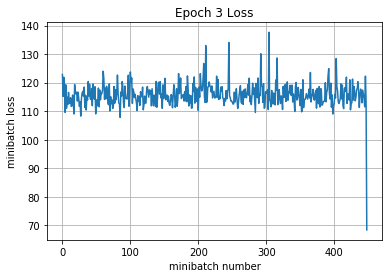

Iteration 1400: with minibatch training loss = 1.92 and accuracy of 0.27
lrate = 0.00433086
Iteration 1500: with minibatch training loss = 1.79 and accuracy of 0.3
lrate = 0.00428665
Iteration 1600: with minibatch training loss = 1.82 and accuracy of 0.2
lrate = 0.0042429
Iteration 1700: with minibatch training loss = 1.73 and accuracy of 0.34
lrate = 0.0041996
Epoch 4, Overall loss = 1.81 and accuracy of 0.253


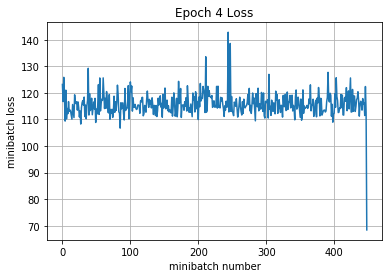

Iteration 1800: with minibatch training loss = 1.71 and accuracy of 0.36
lrate = 0.00415674
Iteration 1900: with minibatch training loss = 1.87 and accuracy of 0.2
lrate = 0.00411431
Iteration 2000: with minibatch training loss = 1.83 and accuracy of 0.25
lrate = 0.00407232
Iteration 2100: with minibatch training loss = 1.99 and accuracy of 0.22
lrate = 0.00403076
Iteration 2200: with minibatch training loss = 1.85 and accuracy of 0.22
lrate = 0.00398962
Epoch 5, Overall loss = 1.81 and accuracy of 0.252


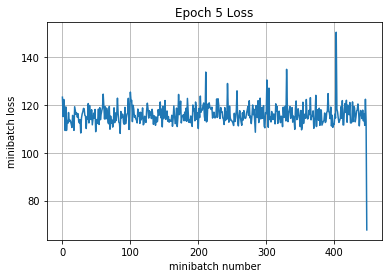

Iteration 2300: with minibatch training loss = 1.83 and accuracy of 0.27
lrate = 0.0039489
Iteration 2400: with minibatch training loss = 1.79 and accuracy of 0.25
lrate = 0.0039086
Iteration 2500: with minibatch training loss = 1.8 and accuracy of 0.31
lrate = 0.00386871
Iteration 2600: with minibatch training loss = 1.75 and accuracy of 0.28
lrate = 0.00382922
Epoch 6, Overall loss = 1.81 and accuracy of 0.252


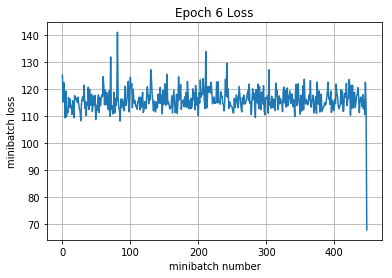

Iteration 2700: with minibatch training loss = 1.74 and accuracy of 0.28
lrate = 0.00379014
Iteration 2800: with minibatch training loss = 1.79 and accuracy of 0.22
lrate = 0.00375146
Iteration 2900: with minibatch training loss = 1.84 and accuracy of 0.2
lrate = 0.00371317
Iteration 3000: with minibatch training loss = 1.8 and accuracy of 0.25
lrate = 0.00367527
Iteration 3100: with minibatch training loss = 1.78 and accuracy of 0.3
lrate = 0.00363795
Epoch 7, Overall loss = 1.81 and accuracy of 0.252


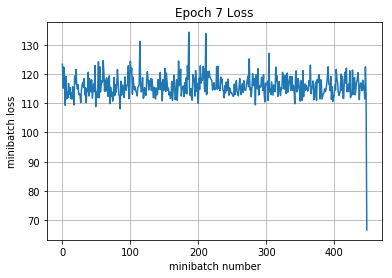

Iteration 3200: with minibatch training loss = 1.82 and accuracy of 0.25
lrate = 0.00360063
Iteration 3300: with minibatch training loss = 1.76 and accuracy of 0.25
lrate = 0.00356388
Iteration 3400: with minibatch training loss = 1.78 and accuracy of 0.27
lrate = 0.00352751
Iteration 3500: with minibatch training loss = 1.81 and accuracy of 0.23
lrate = 0.00349151
Epoch 8, Overall loss = 1.81 and accuracy of 0.252


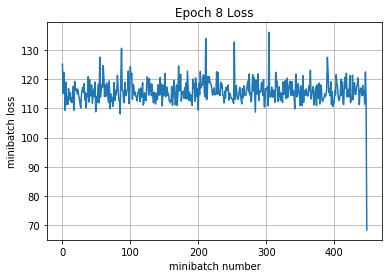

Iteration 3600: with minibatch training loss = 1.75 and accuracy of 0.28
lrate = 0.00345587
Iteration 3700: with minibatch training loss = 1.78 and accuracy of 0.3
lrate = 0.0034206
Iteration 3800: with minibatch training loss = 1.89 and accuracy of 0.22
lrate = 0.00338569
Iteration 3900: with minibatch training loss = 1.83 and accuracy of 0.2
lrate = 0.00335113
Iteration 4000: with minibatch training loss = 1.77 and accuracy of 0.3
lrate = 0.00331693
Epoch 9, Overall loss = 1.81 and accuracy of 0.252


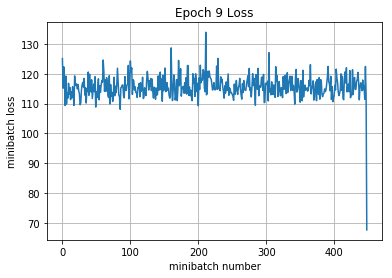

Iteration 4100: with minibatch training loss = 1.83 and accuracy of 0.22
lrate = 0.00328308
Iteration 4200: with minibatch training loss = 1.77 and accuracy of 0.25
lrate = 0.00324957
Iteration 4300: with minibatch training loss = 1.79 and accuracy of 0.16
lrate = 0.0032164
Iteration 4400: with minibatch training loss = 1.81 and accuracy of 0.22
lrate = 0.00318358
Epoch 10, Overall loss = 1.82 and accuracy of 0.252


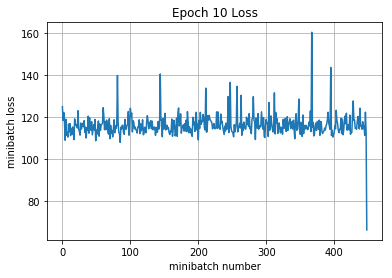

Validation
Epoch 1, Overall loss = 1.82 and accuracy of 0.25


In [58]:
tf.reset_default_graph()
X = tf.placeholder(tf.float32,shape=[None,2304],name='X')
y = tf.placeholder(tf.int64,shape=[None],name='y')
is_training = tf.placeholder(tf.bool)
global_step = tf.Variable(0,trainable=False) # to decay learning rate!!
incrementer = tf.assign(global_step , global_step + 1)
learning_rate = tf.train.exponential_decay(5e-3,global_step=global_step,decay_steps=1000,decay_rate=0.95)
y_out = model1(X,y,seed)

total_loss = tf.losses.softmax_cross_entropy(tf.one_hot(y,7),y_out)
mean_loss = tf.reduce_mean(total_loss)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_step = optimizer.minimize(total_loss,global_step=global_step)

with tf.Session() as sess:
    with tf.device("/gpu:0"): #"/cpu:0" or "/gpu:0" 
        sess.run(tf.global_variables_initializer())
        print('Training')
        run_model(sess,y_out,mean_loss,X_train,y_train,10,64,100,train_step,True,incrementer,learning_rate)
        print('Validation')
        run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

# model2 
a bigger model
5000,1000,100,100,7 units in respective layers with xaviers initialisation

Training
Iteration 0: with minibatch training loss = 25.9 and accuracy of 0.16
Iteration 100: with minibatch training loss = 1.91 and accuracy of 0.2
Iteration 200: with minibatch training loss = 1.72 and accuracy of 0.33
Iteration 300: with minibatch training loss = 1.81 and accuracy of 0.2
Iteration 400: with minibatch training loss = 1.76 and accuracy of 0.3
Epoch 1, Overall loss = 235 and accuracy of 0.241

Validation
Epoch 1, Overall loss = 1.81 and accuracy of 0.249

68.9561822414 112.804779053


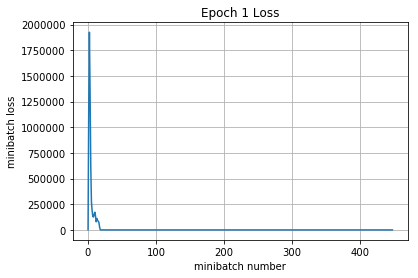

Iteration 500: with minibatch training loss = 1.75 and accuracy of 0.3
Iteration 600: with minibatch training loss = 1.91 and accuracy of 0.19
Iteration 700: with minibatch training loss = 1.76 and accuracy of 0.28
Iteration 800: with minibatch training loss = 1.85 and accuracy of 0.34
Epoch 2, Overall loss = 1.81 and accuracy of 0.251

Validation
Epoch 1, Overall loss = 1.81 and accuracy of 0.249

68.9475195408 112.812591553


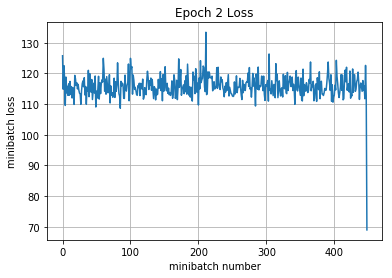

Validation
Epoch 1, Overall loss = 1.81 and accuracy of 0.249



In [21]:
tf.reset_default_graph()
X = tf.placeholder(tf.float32,shape=[None,2304],name='X')
y = tf.placeholder(tf.int64,shape=[None],name='y')
is_training = tf.placeholder(tf.bool)
# global_step = tf.Variable(0,trainable=False) # to decay learning rate!!
# learning_rate = tf.train.exponential_decay(1e-1,global_step=global_step,decay_steps=10000,decay_rate=0.97)
y_out = model2(X,y,seed)

total_loss = tf.losses.softmax_cross_entropy(tf.one_hot(y,7),y_out)
mean_loss = tf.reduce_mean(total_loss)
optimizer = tf.train.AdamOptimizer(learning_rate=1e-2)
train_step = optimizer.minimize(total_loss)

with tf.Session() as sess:
    with tf.device("/cpu:0"): #"/cpu:0" or "/gpu:0" 
        sess.run(tf.global_variables_initializer())
        print('Training')
        run_model(sess,y_out,mean_loss,X_train,y_train,2,64,100,train_step,True)
        print('Validation')
        run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

# model3
tried reducing the umber of layers to see effect on accuracy
5000,300,100,7

Training
Iteration 0: with minibatch training loss = 44.8 and accuracy of 0.14
Iteration 100: with minibatch training loss = 26.7 and accuracy of 0.23
Iteration 200: with minibatch training loss = 8.12 and accuracy of 0.25
Iteration 300: with minibatch training loss = 5.78 and accuracy of 0.19
Iteration 400: with minibatch training loss = 2.94 and accuracy of 0.38
Epoch 1, Overall loss = 21.8 and accuracy of 0.258

Validation
Epoch 1, Overall loss = 2.79 and accuracy of 0.296



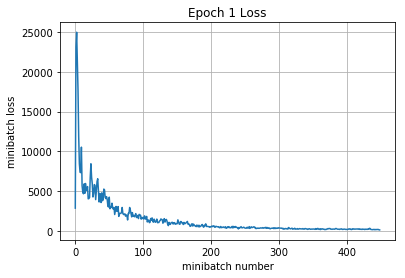

Iteration 500: with minibatch training loss = 2.27 and accuracy of 0.34
Iteration 600: with minibatch training loss = 1.82 and accuracy of 0.39
Iteration 700: with minibatch training loss = 2.11 and accuracy of 0.34
Iteration 800: with minibatch training loss = 1.67 and accuracy of 0.42
Epoch 2, Overall loss = 2.03 and accuracy of 0.353

Validation
Epoch 1, Overall loss = 2.1 and accuracy of 0.305



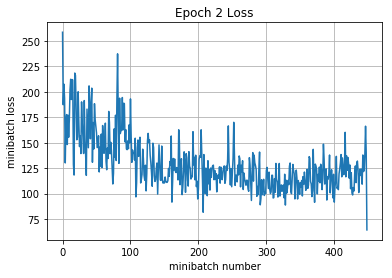

Validation
Epoch 1, Overall loss = 2.1 and accuracy of 0.305



In [28]:
tf.reset_default_graph()
X = tf.placeholder(tf.float32,shape=[None,2304],name='X')
y = tf.placeholder(tf.int64,shape=[None],name='y')
is_training = tf.placeholder(tf.bool)
y_out = model3(X,y,seed)

total_loss = tf.losses.softmax_cross_entropy(tf.one_hot(y,7),y_out)
mean_loss = tf.reduce_mean(total_loss)
optimizer = tf.train.AdamOptimizer(learning_rate=1e-3)
train_step = optimizer.minimize(total_loss)

with tf.Session() as sess:
    with tf.device("/cpu:0"): #"/cpu:0" or "/gpu:0" 
        sess.run(tf.global_variables_initializer())
        print('Training')
        run_model(sess,y_out,mean_loss,X_train,y_train,2,64,100,train_step,True)
        print('Validation')
        run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

** In the above model even training on only 1000 examples for 10 epochs we got an accuracy of ~23 % which is almost equal to training on full dataset for one epoch **

# model 4
model3 with batch norm

Training
Iteration 0: with minibatch training loss = 2.1 and accuracy of 0.14
Iteration 100: with minibatch training loss = 1.86 and accuracy of 0.25
Iteration 200: with minibatch training loss = 1.63 and accuracy of 0.41
Iteration 300: with minibatch training loss = 1.75 and accuracy of 0.23
Iteration 400: with minibatch training loss = 1.53 and accuracy of 0.39
Epoch 1, Overall loss = 1.68 and accuracy of 0.329

Validation
Epoch 1, Overall loss = 1.61 and accuracy of 0.371



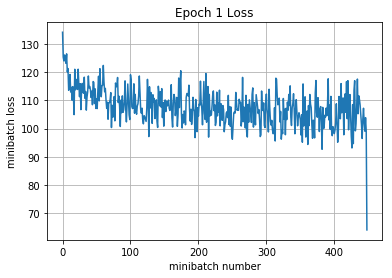

Iteration 500: with minibatch training loss = 1.52 and accuracy of 0.44
Iteration 600: with minibatch training loss = 1.66 and accuracy of 0.39
Iteration 700: with minibatch training loss = 1.46 and accuracy of 0.45
Iteration 800: with minibatch training loss = 1.53 and accuracy of 0.42
Epoch 2, Overall loss = 1.6 and accuracy of 0.373

Validation
Epoch 1, Overall loss = 1.59 and accuracy of 0.381



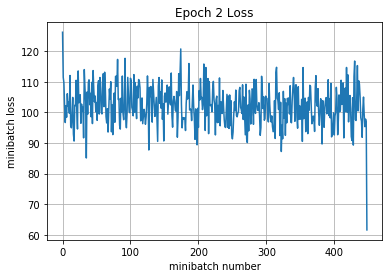

Validation
Epoch 1, Overall loss = 1.59 and accuracy of 0.381



In [12]:
tf.reset_default_graph()
X = tf.placeholder(tf.float32,shape=[None,2304],name='X')
y = tf.placeholder(tf.int64,shape=[None],name='y')
is_training = tf.placeholder(tf.bool)
y_out = model4(X,y,seed)

total_loss = tf.losses.softmax_cross_entropy(tf.one_hot(y,7),y_out)
mean_loss = tf.reduce_mean(total_loss)
optimizer = tf.train.AdamOptimizer(learning_rate=5e-3)

# BN in tensorflow requires this extra dependency according to CS231n
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)
# train_step = optimizer.minimize(total_loss)

with tf.Session() as sess:
    with tf.device("/cpu:0"): #"/cpu:0" or "/gpu:0" 
        sess.run(tf.global_variables_initializer())
        print('Training')
        run_model(sess,y_out,mean_loss,X_train,y_train,2,64,100,train_step,True)
        print('Validation')
        run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

# model5
trying using batchnormalisation on the input as well. Conclusion - no significant improvement! :(

Training
Iteration 0: with minibatch training loss = 2.09 and accuracy of 0.11
Iteration 100: with minibatch training loss = 1.82 and accuracy of 0.28
Iteration 200: with minibatch training loss = 1.63 and accuracy of 0.33
Iteration 300: with minibatch training loss = 1.71 and accuracy of 0.23
Iteration 400: with minibatch training loss = 1.52 and accuracy of 0.36
Epoch 1, Overall loss = 1.68 and accuracy of 0.332

Validation
Epoch 1, Overall loss = 1.63 and accuracy of 0.363



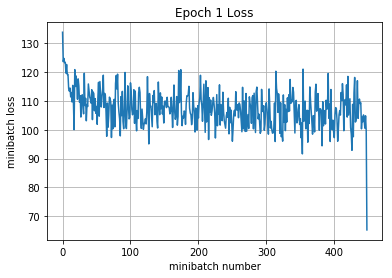

Iteration 500: with minibatch training loss = 1.55 and accuracy of 0.39
Iteration 600: with minibatch training loss = 1.67 and accuracy of 0.33
Iteration 700: with minibatch training loss = 1.49 and accuracy of 0.5
Iteration 800: with minibatch training loss = 1.52 and accuracy of 0.41
Epoch 2, Overall loss = 1.62 and accuracy of 0.358

Validation
Epoch 1, Overall loss = 1.61 and accuracy of 0.366



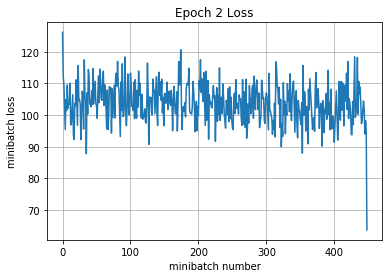

Validation
Epoch 1, Overall loss = 1.61 and accuracy of 0.366



In [21]:
tf.reset_default_graph()
X = tf.placeholder(tf.float32,shape=[None,2304],name='X')
y = tf.placeholder(tf.int64,shape=[None],name='y')
is_training = tf.placeholder(tf.bool)
y_out = model5(X,y,seed)

total_loss = tf.losses.softmax_cross_entropy(tf.one_hot(y,7),y_out)
mean_loss = tf.reduce_mean(total_loss)
optimizer = tf.train.AdamOptimizer(learning_rate=7e-3)

# BN in tensorflow requires this extra dependency according to CS231n
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

with tf.Session() as sess:
    with tf.device("/cpu:0"): #"/cpu:0" or "/gpu:0" 
        sess.run(tf.global_variables_initializer())
        print('Training')
        run_model(sess,y_out,mean_loss,X_train,y_train,2,64,100,train_step,True)
        print('Validation')
        run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

### Model 6
2 conv layer Convnet :D

Training
Iteration 0: with minibatch training loss = 33 and accuracy of 0.047
Iteration 100: with minibatch training loss = 1.97 and accuracy of 0.2
Iteration 200: with minibatch training loss = 1.71 and accuracy of 0.33
Iteration 300: with minibatch training loss = 1.81 and accuracy of 0.2
Iteration 400: with minibatch training loss = 1.75 and accuracy of 0.3
Epoch 1, Overall loss = 77.9 and accuracy of 0.248

Validation
Epoch 1, Overall loss = 1.82 and accuracy of 0.249



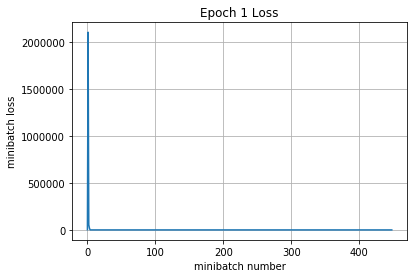

Validation
Epoch 1, Overall loss = 1.82 and accuracy of 0.249



In [38]:
tf.reset_default_graph()
X = tf.placeholder(tf.float32,shape=[None,2304],name='X')
y = tf.placeholder(tf.int64,shape=[None],name='y')
is_training = tf.placeholder(tf.bool)
y_out = model6(X,y,seed=seed,is_training=is_training)

global_step = tf.Variable(1, trainable=False)
starter_learning_rate = 0.1
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                           1, 0.96, staircase=True)

total_loss = tf.losses.softmax_cross_entropy(tf.one_hot(y,7),y_out)
mean_loss = tf.reduce_mean(total_loss)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_step = optimizer.minimize(mean_loss)

# # BN in tensorflow requires this extra dependency according to CS231n
# extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
# with tf.control_dependencies(extra_update_ops):
#     train_step = optimizer.minimize(mean_loss)

with tf.Session() as sess:
    with tf.device("/cpu:0"): #"/cpu:0" or "/gpu:0" 
        sess.run(tf.global_variables_initializer())
        print('Training')
        run_model(sess,y_out,mean_loss,X_train,y_train,1,64,100,train_step,True)
        print('Validation')
        run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

### Model 7
convnet with batchnorm!

Training
Iteration 0: with minibatch training loss = 2.7 and accuracy of 0.094
lrate = 0.001
Iteration 100: with minibatch training loss = 1.99 and accuracy of 0.34
lrate = 0.00099097
Iteration 200: with minibatch training loss = 1.82 and accuracy of 0.34
lrate = 0.000981932
Iteration 300: with minibatch training loss = 1.91 and accuracy of 0.25
lrate = 0.000973153
Iteration 400: with minibatch training loss = 1.51 and accuracy of 0.5
lrate = 0.000964365
Iteration 500: with minibatch training loss = 1.23 and accuracy of 0.5
lrate = 0.000955657
Iteration 600: with minibatch training loss = 1.4 and accuracy of 0.44
lrate = 0.000947027
Iteration 700: with minibatch training loss = 1.36 and accuracy of 0.47
lrate = 0.000938475
Iteration 800: with minibatch training loss = 1.42 and accuracy of 0.5
lrate = 0.00093
Epoch 1, Overall loss = 1.71 and accuracy of 0.399


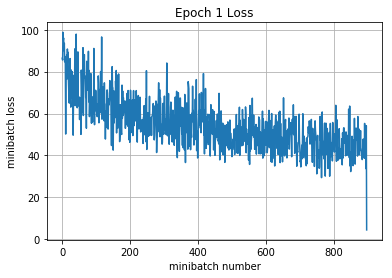

Iteration 900: with minibatch training loss = 1.3 and accuracy of 0.44
lrate = 0.000921602
Iteration 1000: with minibatch training loss = 1.51 and accuracy of 0.47
lrate = 0.00091328
Iteration 1100: with minibatch training loss = 1.54 and accuracy of 0.41
lrate = 0.000905032
Iteration 1200: with minibatch training loss = 1.01 and accuracy of 0.53
lrate = 0.00089686
Iteration 1300: with minibatch training loss = 1.62 and accuracy of 0.44
lrate = 0.00088868
Iteration 1400: with minibatch training loss = 1.22 and accuracy of 0.5
lrate = 0.000880735
Iteration 1500: with minibatch training loss = 1.18 and accuracy of 0.66
lrate = 0.000872782
Iteration 1600: with minibatch training loss = 1.08 and accuracy of 0.66
lrate = 0.0008649
Iteration 1700: with minibatch training loss = 1.01 and accuracy of 0.53
lrate = 0.00085709
Epoch 2, Overall loss = 1.27 and accuracy of 0.518


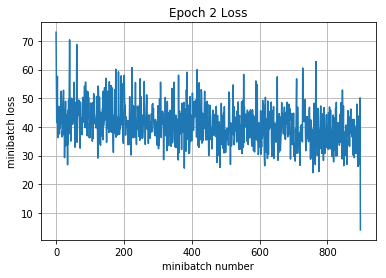

Iteration 1800: with minibatch training loss = 1.39 and accuracy of 0.38
lrate = 0.00084935
Iteration 1900: with minibatch training loss = 1.5 and accuracy of 0.5
lrate = 0.00084168
Iteration 2000: with minibatch training loss = 1.29 and accuracy of 0.53
lrate = 0.000834079
Iteration 2100: with minibatch training loss = 0.979 and accuracy of 0.72
lrate = 0.000826547
Iteration 2200: with minibatch training loss = 1.46 and accuracy of 0.41
lrate = 0.000819083
Iteration 2300: with minibatch training loss = 1.04 and accuracy of 0.62
lrate = 0.000811687
Iteration 2400: with minibatch training loss = 0.793 and accuracy of 0.72
lrate = 0.000804284
Iteration 2500: with minibatch training loss = 0.891 and accuracy of 0.66
lrate = 0.000797021
Iteration 2600: with minibatch training loss = 1.12 and accuracy of 0.69
lrate = 0.000789824
Epoch 3, Overall loss = 1.11 and accuracy of 0.581


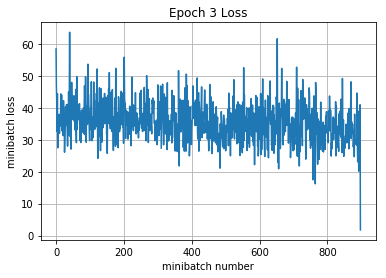

Iteration 2700: with minibatch training loss = 0.962 and accuracy of 0.72
lrate = 0.000782762
Iteration 2800: with minibatch training loss = 0.722 and accuracy of 0.75
lrate = 0.000775694
Iteration 2900: with minibatch training loss = 0.799 and accuracy of 0.69
lrate = 0.000768689
Iteration 3000: with minibatch training loss = 1.04 and accuracy of 0.56
lrate = 0.000761748
Iteration 3100: with minibatch training loss = 0.959 and accuracy of 0.59
lrate = 0.000754869
Iteration 3200: with minibatch training loss = 0.866 and accuracy of 0.66
lrate = 0.000748052
Iteration 3300: with minibatch training loss = 0.76 and accuracy of 0.78
lrate = 0.000741297
Iteration 3400: with minibatch training loss = 0.931 and accuracy of 0.72
lrate = 0.000734603
Iteration 3500: with minibatch training loss = 1.2 and accuracy of 0.5
lrate = 0.000727969
Epoch 4, Overall loss = 0.965 and accuracy of 0.638


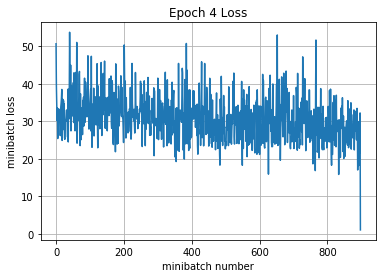

Iteration 3600: with minibatch training loss = 0.954 and accuracy of 0.72
lrate = 0.000721395
Iteration 3700: with minibatch training loss = 0.808 and accuracy of 0.69
lrate = 0.000714881
Iteration 3800: with minibatch training loss = 0.902 and accuracy of 0.62
lrate = 0.000708425
Iteration 3900: with minibatch training loss = 0.888 and accuracy of 0.66
lrate = 0.000702028
Iteration 4000: with minibatch training loss = 0.992 and accuracy of 0.62
lrate = 0.000695625
Iteration 4100: with minibatch training loss = 0.655 and accuracy of 0.69
lrate = 0.000689406
Iteration 4200: with minibatch training loss = 0.795 and accuracy of 0.69
lrate = 0.000683181
Iteration 4300: with minibatch training loss = 0.852 and accuracy of 0.72
lrate = 0.000677011
Iteration 4400: with minibatch training loss = 0.585 and accuracy of 0.78
lrate = 0.000670898
Epoch 5, Overall loss = 0.797 and accuracy of 0.704


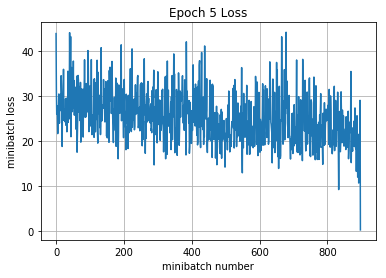

Iteration 4500: with minibatch training loss = 0.645 and accuracy of 0.75
lrate = 0.000664839
Iteration 4600: with minibatch training loss = 0.7 and accuracy of 0.75
lrate = 0.000658835
Iteration 4700: with minibatch training loss = 0.675 and accuracy of 0.72
lrate = 0.000652886
Iteration 4800: with minibatch training loss = 0.477 and accuracy of 0.81
lrate = 0.00064699
Iteration 4900: with minibatch training loss = 0.638 and accuracy of 0.84
lrate = 0.000641148
Iteration 5000: with minibatch training loss = 0.421 and accuracy of 0.84
lrate = 0.000635358
Iteration 5100: with minibatch training loss = 0.506 and accuracy of 0.91
lrate = 0.00062962
Iteration 5200: with minibatch training loss = 0.416 and accuracy of 0.84
lrate = 0.000623878
Iteration 5300: with minibatch training loss = 0.797 and accuracy of 0.69
lrate = 0.0006183
Epoch 6, Overall loss = 0.605 and accuracy of 0.777


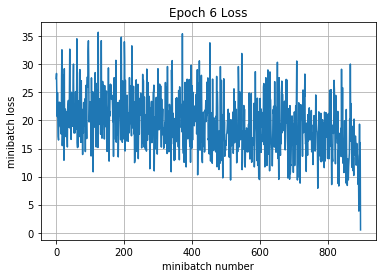

Iteration 5400: with minibatch training loss = 0.423 and accuracy of 0.88
lrate = 0.000612661
Iteration 5500: with minibatch training loss = 0.386 and accuracy of 0.91
lrate = 0.000607184
Iteration 5600: with minibatch training loss = 0.381 and accuracy of 0.88
lrate = 0.000601701
Iteration 5700: with minibatch training loss = 0.382 and accuracy of 0.88
lrate = 0.000596213
Iteration 5800: with minibatch training loss = 0.463 and accuracy of 0.81
lrate = 0.000590883
Iteration 5900: with minibatch training loss = 0.37 and accuracy of 0.88
lrate = 0.000585494
Iteration 6000: with minibatch training loss = 0.453 and accuracy of 0.88
lrate = 0.000580259
Iteration 6100: with minibatch training loss = 0.361 and accuracy of 0.84
lrate = 0.00057502
Iteration 6200: with minibatch training loss = 0.441 and accuracy of 0.78
lrate = 0.000569775
Epoch 7, Overall loss = 0.438 and accuracy of 0.84


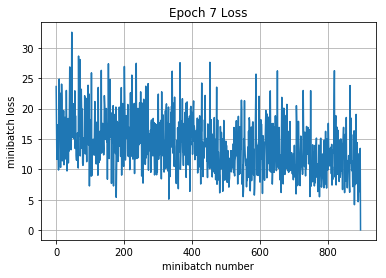

Iteration 6300: with minibatch training loss = 0.529 and accuracy of 0.81
lrate = 0.00056463
Iteration 6400: with minibatch training loss = 0.428 and accuracy of 0.81
lrate = 0.000559582
Iteration 6500: with minibatch training loss = 0.335 and accuracy of 0.88
lrate = 0.000554529
Iteration 6600: with minibatch training loss = 0.342 and accuracy of 0.91
lrate = 0.000549521
Iteration 6700: with minibatch training loss = 0.378 and accuracy of 0.78
lrate = 0.000544559
Iteration 6800: with minibatch training loss = 0.168 and accuracy of 0.97
lrate = 0.000539592
Iteration 6900: with minibatch training loss = 0.238 and accuracy of 0.94
lrate = 0.000534768
Iteration 7000: with minibatch training loss = 0.327 and accuracy of 0.91
lrate = 0.000529939
Iteration 7100: with minibatch training loss = 0.163 and accuracy of 0.97
lrate = 0.000525106
Epoch 8, Overall loss = 0.307 and accuracy of 0.888


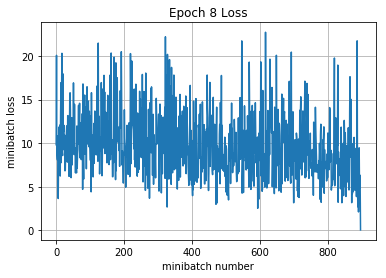

Iteration 7200: with minibatch training loss = 0.349 and accuracy of 0.88
lrate = 0.000520364
Iteration 7300: with minibatch training loss = 0.126 and accuracy of 0.97
lrate = 0.000515712
Iteration 7400: with minibatch training loss = 0.166 and accuracy of 0.97
lrate = 0.000511055
Iteration 7500: with minibatch training loss = 0.191 and accuracy of 0.88
lrate = 0.00050644
Iteration 7600: with minibatch training loss = 0.135 and accuracy of 0.94
lrate = 0.000501866
Iteration 7700: with minibatch training loss = 0.165 and accuracy of 0.94
lrate = 0.000497334
Iteration 7800: with minibatch training loss = 0.106 and accuracy of 0.97
lrate = 0.000492843
Iteration 7900: with minibatch training loss = 0.166 and accuracy of 0.94
lrate = 0.000488393
Iteration 8000: with minibatch training loss = 0.142 and accuracy of 0.91
lrate = 0.000483938
Epoch 9, Overall loss = 0.221 and accuracy of 0.92


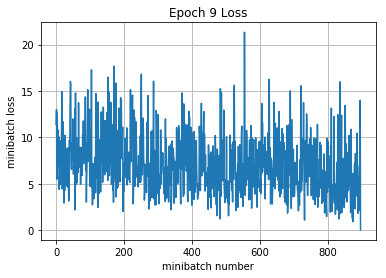

Iteration 8100: with minibatch training loss = 0.127 and accuracy of 0.94
lrate = 0.000479612
Iteration 8200: with minibatch training loss = 0.0536 and accuracy of 1
lrate = 0.000475281
Iteration 8300: with minibatch training loss = 0.182 and accuracy of 0.94
lrate = 0.000470989
Iteration 8400: with minibatch training loss = 0.164 and accuracy of 0.91
lrate = 0.000466736
Iteration 8500: with minibatch training loss = 0.0742 and accuracy of 1
lrate = 0.000462521
Iteration 8600: with minibatch training loss = 0.0952 and accuracy of 0.97
lrate = 0.000458344
Iteration 8700: with minibatch training loss = 0.147 and accuracy of 0.94
lrate = 0.000454205
Iteration 8800: with minibatch training loss = 0.187 and accuracy of 0.94
lrate = 0.000450104
Iteration 8900: with minibatch training loss = 0.178 and accuracy of 0.94
lrate = 0.000446039
Epoch 10, Overall loss = 0.161 and accuracy of 0.946


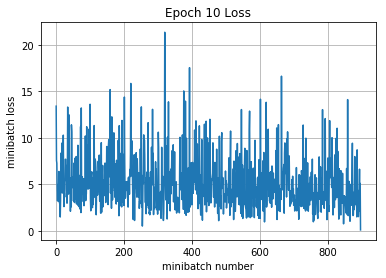

Validation
Epoch 1, Overall loss = 2.09 and accuracy of 0.565


In [61]:
tf.reset_default_graph()
X = tf.placeholder(tf.float32,shape=[None,2304],name='X')
y = tf.placeholder(tf.int64,shape=[None],name='y')
is_training = tf.placeholder(tf.bool)
y_out = model7(X,y,seed=seed,is_training=is_training)

global_step = tf.Variable(0, trainable=False)
incrementer = tf.assign(global_step,global_step + 1)
starter_learning_rate =1e-3
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                           800, 0.93, staircase=False)
total_loss = tf.losses.softmax_cross_entropy(tf.one_hot(y,7),y_out)
mean_loss = tf.reduce_mean(total_loss)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
# train_step = optimizer.minimize(mean_loss)

# # BN in tensorflow requires this extra dependency according to CS231n
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

with tf.Session() as sess:
    with tf.device("/gpu:0"): #"/cpu:0" or "/gpu:0" 
        sess.run(tf.global_variables_initializer())
        print('Training')
        run_model(sess,y_out,mean_loss,X_train,y_train,10,32,100,train_step,True,incrementer,learning_rate)
        print('Validation')
        run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

In [8]:
from dbn.tensorflow import SupervisedDBNClassification

In [4]:
clf =  SupervisedDBNClassification(hidden_layers_structure=[256, 256],
                                         learning_rate_rbm=0.05,
                                         learning_rate=0.1,
                                         n_epochs_rbm=10,
                                         n_iter_backprop=100,
                                         batch_size=32,
                                         activation_function='relu',
                                         dropout_p=0.2)

clf.fit(X_train,y_train)

analysis.ipynb	deep-belief-network  model.py	preprocessing.py  README.md
data		images.jpeg	     model.py~	__pycache__	  train.ipynb


In [ ]:
clf.score(X_val,y_val)